In [1]:
import requests
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import time
import os
import numpy as np
import nltk
import spacy
import string
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import builtins
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
from gensim.models import TfidfModel, Phrases, phrases, CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim.models.ldamodel as LDAModel
from gensim.test.utils import datapath
from gensim.corpora import MmCorpus
pyLDAvis.enable_notebook()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Scraper
I scraped the data off of the Stanford Encyclopedia of Philosophy at random. I saved the body of each document to a text file.

In [2]:
"""
NUM_DOCS = 3000
directory = 'pages//'
docs = []

def clean_filename(filename):
    filename = unidecode(filename)
    bad_chars = ['‘', '\'']
    for char in bad_chars:
        if char in filename:
            print(filename)
            filename = filename.replace(char, '')
    return filename

while len(os.listdir('pages//')) < NUM_DOCS:
    # load a page
    url = 'https://plato.stanford.edu/cgi-bin/encyclopedia/random'
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    
    # Locate the title and clean it up
    # Every title contains the name of the site, so that is removed
    # Forward slashes are replaced with dashes
    title = ' '.join(soup.title.text.strip('\n').split()[:-4]).replace('/', '-')
    title = clean_filename(title)
    # Save the body of the document
    if title not in docs:
        docs.append(title)
        body = soup.find('div', id='main-text')
        # A minority of pages did not have anything in the body
        if body:
            paragraphs = '\n'.join([paragraph.text.strip('\n') for paragraph in body.find_all('p')])
            with open(f'{directory+title}.txt', 'w', encoding='utf8') as f:
                for paragraph in paragraphs:
                    f.write(paragraph)
    count = len(os.listdir('pages//'))
    if not count % 500:
        print(count)
    
    
    # sleep to be nice
    time.sleep(3)"""

"\nNUM_DOCS = 3000\ndirectory = 'pages//'\ndocs = []\n\ndef clean_filename(filename):\n    filename = unidecode(filename)\n    bad_chars = ['‘', ''']\n    for char in bad_chars:\n        if char in filename:\n            print(filename)\n            filename = filename.replace(char, '')\n    return filename\n\nwhile len(os.listdir('pages//')) < NUM_DOCS:\n    # load a page\n    url = 'https://plato.stanford.edu/cgi-bin/encyclopedia/random'\n    page = requests.get(url)\n    soup = bs(page.content, 'html.parser')\n    \n    # Locate the title and clean it up\n    # Every title contains the name of the site, so that is removed\n    # Forward slashes are replaced with dashes\n    title = ' '.join(soup.title.text.strip('\n').split()[:-4]).replace('/', '-')\n    title = clean_filename(title)\n    # Save the body of the document\n    if title not in docs:\n        docs.append(title)\n        body = soup.find('div', id='main-text')\n        # A minority of pages did not have anything in the b

# Read in the Documents

In [3]:
doc_dir = 'pages//'
doc_locations = []
for file in os.listdir(doc_dir):
    if file.split('.')[-1] == 'txt':
        doc_locations.append(doc_dir+file)

In [4]:
raw_docs = []
for loc in doc_locations:
    with open(loc, encoding='utf8') as f:
        raw_docs.append('\n'.join(f.readlines()))
print(f'There are {len(raw_docs)} documents')

There are 1730 documents


# Tokenization
Documents are split into tokens, with each word being a token.

In [5]:
tokenizer = nltk.tokenize.word_tokenize
tokenized_docs = [tokenizer(doc) for doc in tqdm(raw_docs)]

100%|██████████| 1730/1730 [01:16<00:00, 22.64it/s]


# Lemmatization
A lemma is the "base" form of a word given the word's part of speech. For example, the lemma of "running" is "run," the lemma of "cares" is "care" and so on. Lemmatization reduces words to their lemmas. Since lemmatization is part of speech dependent, each word must first be tagged with its part of speech.

I use lemmatization here because I am only introduced in the meaning of words regardless of their form. For example, the difference between "cares," "caring," "cared" and so on are meaningless for this application. An added bonus is that lemmatization will reduce the number of unique words in the text.

Note when tagging the part of speech, there is a catch all category of words that are not lemmatized. This catches tokens that would not be lemmatized anyway like numbers, conjunctions and determiners ("all," "every," etc.).

In [6]:
lemmatized_docs = []
lemmatizer = WordNetLemmatizer()

# Takes an untagged document, a sequence of tokens, tags each token in the
# document with a part of speech, and converts those tags into a form that
# the lemmatizer can use.
# Returns a tagged document, a list of tuples in the form (token, PoS)
def tagger(untagged_doc):
    tagged_doc = nltk.pos_tag(untagged_doc)
    formatted_tags = []
    for tok in tagged_doc:
        unformatted_tag = tok[1]
        # Convert POS tags into format usable by nltk
        if unformatted_tag.startswith('N'):
            formatted_tag = wordnet.NOUN
        elif unformatted_tag.startswith('V'):
            formatted_tag = wordnet.VERB
        elif unformatted_tag.startswith('R'):
            formatted_tag = wordnet.ADV
        elif unformatted_tag.startswith('J'):
            formatted_tag = wordnet.ADJ
        # The
        else:
            formatted_tag = unformatted_tag
        formatted_tags.append((tok[0], formatted_tag))
    return formatted_tags
        
    
pos_to_lemmatize = [wordnet.NOUN, wordnet.VERB, wordnet.ADV, wordnet.ADJ]
lemmatized_docs = []

# Select a subset of documents - helps with memory problems
#num_docs = 875
#random.shuffle(tokenized_docs)
#tokenized_docs = tokenized_docs[:num_docs]
#print(f'Selected {num_docs} documents')

# Tag and lemmatize each document
for tokenized_doc in tqdm(tokenized_docs):
    # POS tagging
    tagged_doc = tagger(tokenized_doc)
    # Lemmatization
    lemmatized_doc = [lemmatizer.lemmatize(tok[0], tok[1]) for tok in tagged_doc if tok[1] in pos_to_lemmatize]
    lemmatized_docs.append(lemmatized_doc)

print(f'Lemmatized {len(lemmatized_docs)} documents')

100%|██████████| 1730/1730 [07:26<00:00,  3.87it/s]

Lemmatized 1730 documents


# Remove Stopwords, Punctuation, LaTeX, and Short Words.
The guiding principle has been that I only want to keep meaningful words. As such, I remove the following categories:
* Stopwords: words that are commonly used to the point of meaninglessness (ex. "the," "is")
* Punctuation: Not words and not meaningful
* LaTeX: Not words and not meaningful
* Short words: Unlikely to be meaningful. Most should be caught when removing stopwords, but there may be, for example, variables used in the text (ex. "If X is true").

In [7]:
# SEP has a lot of equations, etc. This helper function will help remove them.
def not_latek(tok):
    bad_chars = string.punctuation
    # Don't want to catch, for example eighteenth-century
    bad_chars = bad_chars.replace('-','')
    for char in bad_chars:
        if char in tok:
            return False
    return True


In [8]:
clean_docs = []
min_tok_length = 3
stopwords = nltk.corpus.stopwords.words('english')
stopwords += string.punctuation
stopwords += ["from", "often", "happen", "later", "hardly", "leave", "proceed", "anything", "make", "take", "different", "something", "others", "word", "also", "give",
             "take", "term", "view", "thus", "kind", "many", "seem", "call", "well", "consider", "case", "point", "rather", "possible", "seem", "even", "thing",
             "vein", "grasped", "rather", "hardly", "onwards", "anything", "think", "need", "know", "example", "however", "hold", "much", 'theory']
bad_toks = set()
for doc in lemmatized_docs:
    clean_doc = []
    for tok in doc:
        if len(tok) > min_tok_length and tok.lower() not in stopwords and not_latek(tok):
            clean_doc.append(tok.lower())
    clean_docs.append(clean_doc)

# Data Exploration

In [9]:
corpus = []
for doc in tqdm(clean_docs):
    corpus += doc
print(f'Combined the {len(clean_docs)} docs into a single list of {len(corpus)} words.')


100%|██████████| 1730/1730 [00:00<00:00, 11950.98it/s]

Combined the 1730 docs into a single list of 8179693 words.


## Document Length

The mean article length is 4728 words.
The shortest article is 54 and the longest is 39097 words.


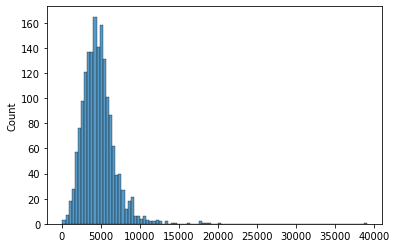

In [10]:
lengths = [len(doc) for doc in clean_docs]
sns.histplot(lengths)

print(f'The mean article length is {int(np.mean(lengths))} words.')
print(f'The shortest article is {np.min(lengths)} and the longest is {np.max(lengths)} words.')

 ## Word Frequencies
 Here, I visualize the 20 most used words across the corpus. This acts as a nice sanity check after processing the data, making sure that most of the top words are meaningful.

<AxesSubplot:>

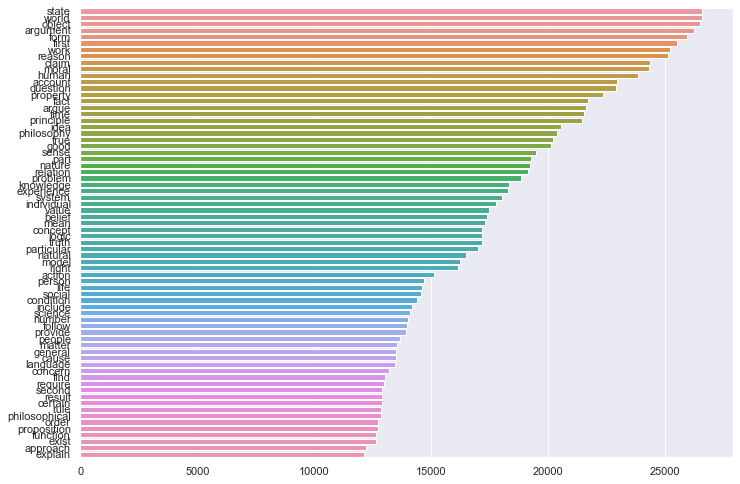

In [11]:
counter = Counter(corpus)
most_common = counter.most_common()

x = []
y = []

sns.set(rc={'figure.figsize':(11.7,8.27)})

for word, count in most_common[:70]:
    x.append(word)
    y.append(count)
sns.barplot(x=y, y=x, orient='h')

Most of the top words are the sort of meaningful words one would expect in a philosophy website. Some are fairly generic (ex. "also" and "take"), but they are the minority. I am not concerned with them unless they are over-represented as relevant terms in the LDA model.

# Word Cloud

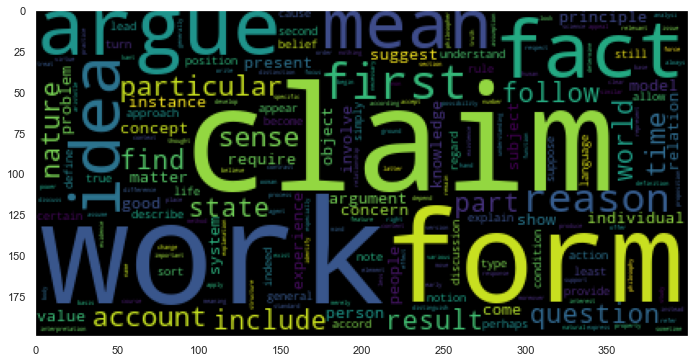

In [12]:
wc = WordCloud()
wc.generate(' '.join(corpus))
plt.imshow(wc)
plt.grid(None)

# Tf-Idf Model
Term-Frequency-Inverse Document Frequency gives a score that quantifies the  importance of certain words. The score for a word increases for the number of times the word is used in the document, but decreases as the word is used more across different documents in the corpus. As such, terms will have higher scores if they are used frequently in relatively few documents, and those terms will presumably be important.

### Bag of Words Vectorization
A bag of words vectorization is a vector representation of a document (or sentence, paragraph, etc.) that does not take into account token order. Each document is represented as a vector with dimensionality equivalent to the size of the number of unique words in the corpus. Each component in the vector represents a token, and the magnitude of the component represents how many times the token is used in the document.

In [13]:
clean_docs
if 'unigram_bow.mm' not in os.listdir():
    # Create unigram dictionary
    unigram_dictionary = Dictionary(clean_docs)
    unigram_dictionary.save_as_text('unigram_dict.txt')

    # Create bag of words models from the unigram representations of the documents
    unigram_bow = [unigram_dictionary.doc2bow(doc) for doc in tqdm(clean_docs)]

    MmCorpus.serialize('unigram_bow.mm', unigram_bow)
else:
    unigram_bow = MmCorpus('unigram_bow.mm')
    unigram_dictionary = Dictionary.load_from_text('unigram_dict.txt')

### Building the Tf-Idf Model

In [14]:
# Create the model
tfidf_unigram = TfidfModel(corpus=unigram_bow, id2word=unigram_dictionary)

#### Visualize tf-idf Score Distribution
Here, I visualize the tf-idf score, so I can pick a reasonable score, below which words will be disposed. Note that this distribution has a very long tail. The limits placed on the x-axis cut off some outliers.

  0%|          | 0/1730 [00:02<?, ?it/s]


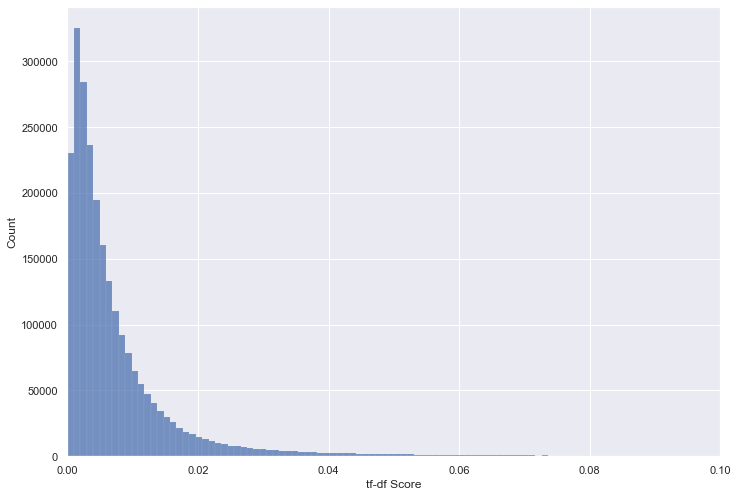

In [15]:
scores = []
idx = []
corpus_length = len(unigram_bow)
unigram_bow = list(unigram_bow)
with tqdm(total=corpus_length, position=0, leave=True) as pbar:
    for i in tqdm(range(corpus_length), position=0, leave=True):
    #for i in range(len(unigram_bow[:10])):
        bow = unigram_bow[i]
        tfidf = tfidf_unigram[bow]
        for tup in tfidf:
            idx.append(tup[0])
            scores.append(tup[1])
        
hist = sns.histplot(scores,bins=1000)
hist.set(xlim=(0,0.1))
hist.set_xlabel('tf-df Score')
plt.show()

In [16]:
cutoff = 0.02
words = []
missing_words = []
corpus_length = len(unigram_bow)
tfidf_bow = []
if 'tfidf_bow.mm' not in os.listdir():
    # Create new bag of words representations of each document, keeping
    # only words above a certain score.
    with tqdm(total=corpus_length, position=0, leave=True) as pbar:
        for i in tqdm(range(corpus_length), position=0, leave=True):
            bow = unigram_bow[i]
            # This list holds all the words
            tfidf_idxs = []
            # This list holds the words with scores below the threshold
            low_val_words = []
            # This list holds the words to keep in the model
            bow_idxs = []
            for idx, value in tfidf_unigram[bow]:
                tfidf_idxs.append(idx)
                if value < cutoff:
                    low_val_words.append(idx)
                else:
                    bow_idxs.append(idx)
            dropped = low_val_words + missing_words
            for item in dropped:
                words.append(unigram_dictionary[item])
            # Missing words are words with zero score
            missing_words = [idx for idx in bow_idxs if idx not in tfidf_idxs]
            # Keeps words above score threshold
            new_bow = [w for w in bow if w[0] not in low_val_words and w[0] not in missing_words]    
            tfidf_bow.append(new_bow)
        MmCorpus.serialize('tfidf_bow.mm', tfidf_bow)
else:
    tfidf_bow = MmCorpus('tfidf_bow.mm')
    

  0%|          | 0/1730 [00:18<?, ?it/s]


# LDA Models

# Unigram

### Tune Topics

In [17]:
# Given a number of topics, trains an LDA model if one has not been saved
# Otherwise, loads an equivalent LDA model.
# Returns the LDA model.
def train_lda(topics, unigram_bow=unigram_bow):
    data_size_folder = f"{len(unigram_bow)} Documents"
    # Use the same name for model folders and files
    model_folder_file = f"lda_model_{len(unigram_bow)}_{topics}"
    
    # Check if any models for a corpus of this size have been saved
    # If not, make a folder to store those models
    if data_size_folder not in os.listdir():
        print(f'Making directory for corpus with {len(unigram_bow)} documents.')
        os.mkdir(data_size_folder)
        
    # Check if any models with a given number of topics have been saved for a corpus of this size
    # If not, make a folder to store the model, train the model, and save it
    if model_folder_file not in os.listdir(data_size_folder):
        print(f'Training a model with {topics} topics on a corpus with {len(unigram_bow)} documents.')
        os.mkdir(os.path.join(data_size_folder, model_folder_file))
        model_loc = os.path.join(data_size_folder,  model_folder_file, model_folder_file)
        lda_model = LDAModel.LdaModel(corpus=tfidf_bow,
                                                   id2word=unigram_dictionary,
                                                   num_topics=topics,
                                                   iterations=100,
                                                   chunksize=100,
                                                   update_every=0,
                                                   passes=300,
                                                   alpha='auto',
                                                   eta='auto',
                                                   random_state=123)
        lda_model.save(model_loc)
    else:
        print(f'Loading trained model for model with {topics} topics.')
        lda_model = LDAModel.LdaModel.load(os.path.join(data_size_folder, model_folder_file, model_folder_file))
    return lda_model


### Coherence by topic
Coherence scores attempt to quantify the interpretability of topic models. Here, coherence scores are used to guide a decision about the number of topics to use. Coherence metrics are imperfect, so the guidance is not entirely authoritative. Here, two metrics are used: a c_v score and Umass coherence. The first metric suggests a higher quality model as it increases, and the second suggests a higher quality model as it approaches zero.


In [20]:
lda_by_topic = [train_lda(i, unigram_bow) for i in range(1,26)]

Making directory for corpus with 1730 documents.
Training a model with 1 topics on a corpus with 1730 documents.
Training a model with 2 topics on a corpus with 1730 documents.
Training a model with 3 topics on a corpus with 1730 documents.
Training a model with 4 topics on a corpus with 1730 documents.
Training a model with 5 topics on a corpus with 1730 documents.
Training a model with 6 topics on a corpus with 1730 documents.
Training a model with 7 topics on a corpus with 1730 documents.
Training a model with 8 topics on a corpus with 1730 documents.
Training a model with 9 topics on a corpus with 1730 documents.
Training a model with 10 topics on a corpus with 1730 documents.
Training a model with 11 topics on a corpus with 1730 documents.
Training a model with 12 topics on a corpus with 1730 documents.
Training a model with 13 topics on a corpus with 1730 documents.
Training a model with 14 topics on a corpus with 1730 documents.
Training a model with 15 topics on a corpus with 1

In [30]:
# Takes a model
# Returns the model's CV score
def coherence_score(lda_model, coherence):
    coherence_model = CoherenceModel(model=lda_model,
                                        corpus=tfidf_bow,
                                        texts=clean_docs,
                                        coherence=coherence,
                                        #window_size=500,
                                        processes=1)
    with np.errstate(invalid='ignore'):
        score = coherence_model.get_coherence()
    return score

scores = [coherence_score(model, 'c_v') for model in tqdm(lda_by_topic)]
u_mass_scores = [coherence_score(model, 'u_mass') for model in tqdm(lda_by_topic)]

100%|██████████| 25/25 [00:01<00:00, 15.64it/s]


Text(0, 0.5, 'Umass Score')

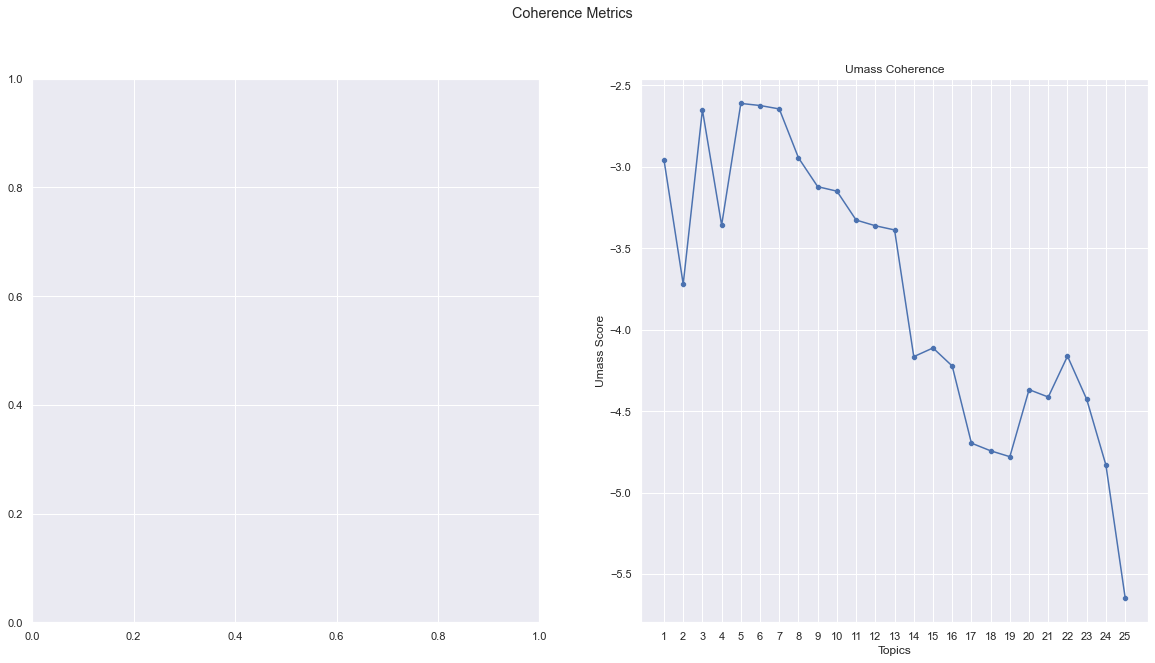

In [60]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle('Coherence Metrics')
sns.lineplot(x=range(1, len(u_mass_scores) + 1),y= u_mass_scores, ax=ax[1])
sns.scatterplot(x=range(1, len(u_mass_scores) + 1), y=u_mass_scores, ax=ax[1])
ax[1].set_title('Umass Coherence')
ax[1].set_xticks(range(1, len(u_mass_scores)+1))
ax[1].set_xlabel('Topics')
ax[1].set_ylabel('Umass Score')
#plt.show()

sns.lineplot(x=range(1, len(scores) + 1),y= scores, ax=ax[0])
sns.scatterplot(x=range(1, len(scores) + 1), y=scores, ax=ax[0])
ax[0].set_title('C-v Coherence')
ax[0].set_xticks(range(1, len(scores)+1))
ax[0].set_xlabel('Topics')
ax[0].set_ylabel('C_v Score')
plt.show()

print(f'Best c_v coherence score is {round(np.max(scores), 4)} at {np.argmax(scores) +1} topics.')
print(f'Best c_umass coherence score is {round(np.max(scores), 4)} at {np.argmax(scores) +1} topics.')

# Visualization and Discussion
Below is a visualization of the topic model with 11 topics. While the coherence score is by nature not authoritative in determining the most interpretable model, in this case, the model with the best score was interpretable.

In [50]:
topics = 11
lda_model = lda_by_topic[topics-1]
vis = gensimvis.prepare(topic_model=lda_model,
                       corpus=tfidf_bow,
                       dictionary=unigram_dictionary,
                       mds='mmds',
                       R=30)
vis

C:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.226225 -0.266549       1        1  15.623479
3      0.409455 -0.038932       2        1  10.846315
8      0.314967  0.155265       3        1  10.807371
4      0.127479  0.342407       4        1   8.931047
6      0.004806 -0.355748       5        1   8.764050
9     -0.345847 -0.028402       6        1   8.504502
7     -0.289079 -0.302098       7        1   8.397846
0     -0.095128  0.353332       8        1   7.850247
5     -0.317583  0.185406       9        1   7.705293
2      0.037488  0.087789      10        1   6.662730
1     -0.072784 -0.132470      11        1   5.907120, topic_info=              Term          Freq         Total Category  logprob  loglift
93296        moral  18308.000000  18308.000000  Default  30.0000  30.0000
83846        logic  13458.000000  13458.000000  Default  29.0000  29.0000
16140       belief  10629.000000  10629.000000  Default  28.0000  28.0000
10953    aristotle   7018.000000   7018.000000  Default  27.0000  27.0000
50081   experience  10114.000000  10114.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
73527    intrinsic    451.202413   1407.467737  Topic11  -5.7596   1.6914
164578       world    520.067887   3725.868977  Topic11  -5.6176   0.8599
82567         life    500.141153   3376.973536  Topic11  -5.6566   0.9192
62956         harm    473.895466   2531.104304  Topic11  -5.7105   1.1536
3172        action    482.283835   5868.625831  Topic11  -5.6930   0.3302

[835 rows x 6 columns], token_table=        Topic      Freq          Term
term                                 
2114        1  0.031535       abelard
2114        7  0.966328       abelard
2159        6  0.995192    abhidharma
2268        9  0.993223         abner
2528        1  0.265125      abstract
...       ...       ...           ...
167902      1  0.998667   łukasiewicz
167961      6  0.990997       śaṅkara
167990      6  0.994573      śrīharṣa
168015      6  0.992968  śāntarakṣita
168018      6  0.991817     śāntideva

[1974 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 9, 5, 7, 10, 8, 1, 6, 3, 2])

The model contains the following topics:

1. Logic
2. Liberal philosophy
3. Moral philosophy
4. Analytics philosophy and Philosophy of Science
5. Idealism
6. Consciousness and Epistemology
7. Classical Philosophy
8. Philosophy of science - biology
9. Experience
10. Physics
11. Individualism

None of these categories are entirely pure. Some categories, like 5 and 11 are unusual.  Others, like 4 group together what a human might otherwise define as a single topic (ex. four has words suggesting a focus on science, game theory and computation, 5 has many terms associated with idealism, but also contains "mathematical," "Newton", plus Descartes can cut either way). Still, even these combinations are composed of areas of interest within philosophy. Other topics, like 2, are very pure, and some, like 10, are nearly pure.

# Conclusion

A topic model was trained on over 1700 articles from the Stanford Encyclopedia of philosophy. The documents were vectorized using a bag of words representation. A custom stopword list was used along with TF-IDF to remove less relevant words. The topic model was developed using Latent Dirichlet Allocation. The model was evaluated using a coherence metric and human interpretation.